In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
from tqdm import tqdm
from time import sleep

Problem Overview

This dataset delves into the problem of illegal transactions involved in money laundering. 
The tricky part of using machine learning models is despite technological advances within the field, the rate of either false positive or false negatives are still relatively high. In the context of this issues, there could be many accounts involved in legitimate transactions to be flagged as illegally laundering and vice versa. 

In [2]:
from dask import dataframe as dd

In [157]:

df = dd.read_csv('HI-Large_Trans.csv')


In [4]:
#Convert to Date_Time
df = df.map_partitions(lambda partition, col = "Timestamp": partition.assign(**{col: pd.to_datetime(partition[col])}), meta = {**{"Timestamp": 'datetime64[ns]'}, **df.dtypes[1:].to_dict()})

In [5]:
df.dtypes

Timestamp             datetime64[ns]
From Bank                      int64
Account                       object
To Bank                        int64
Account.1                     object
Amount Received              float64
Receiving Currency            object
Amount Paid                  float64
Payment Currency              object
Payment Format                object
Is Laundering                  int64
dtype: object

In [6]:
# df = df.assign(Month= lambda partition:  partition["Timestamp"].dt.month)

In [128]:
df.isna().sum().compute()

Timestamp             0
From Bank             0
Account               0
To Bank               0
Account.1             0
Amount Received       0
Receiving Currency    0
Amount Paid           0
Payment Currency      0
Payment Format        0
Is Laundering         0
Month                 0
dtype: int64

In [259]:
month_laundering_count = pd.Series(data = [0,0,0,0,0,0,0,0,0,0,0,0], index = [1,2,3,4,5,6,7,8,9,10,11,12])

for i in tqdm(range(df.npartitions)):
    df_temp = df.get_partition(i).compute()
    month_laundering_temp = df_temp[df_temp["Is Laundering"] == 1]["Month"].value_counts()
    month_laundering_count =  month_laundering_count.add(month_laundering_temp, fill_value=0)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265


In [267]:
month_legal_count = pd.Series(data = [0,0,0,0,0,0,0,0,0,0,0,0], index = [1,2,3,4,5,6,7,8,9,10,11,12])

for i in tqdm(range(df.npartitions), desc='Processing'):
    df_temp = df.get_partition(i).compute()
    month_laundering_temp = df_temp[df_temp["Is Laundering"] == 0]["Month"].value_counts()
    month_legal_count =  month_legal_count.add(month_laundering_temp, fill_value=0)

Processing: 100%|██████████| 266/266 [07:00<00:00,  1.58s/it]


Text(0.5, 0, 'Month')

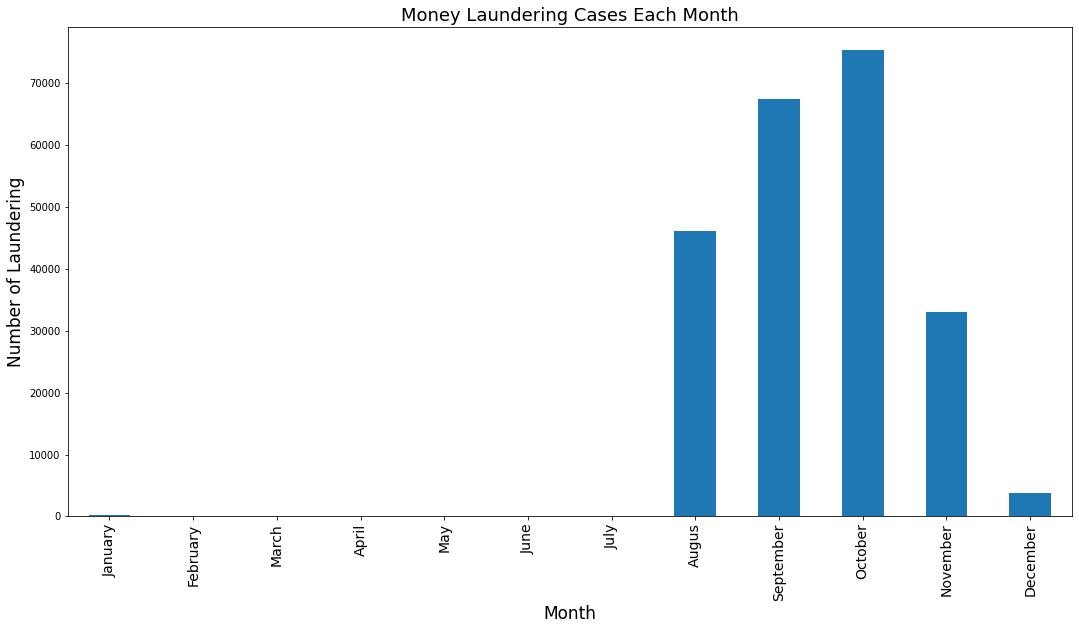

In [262]:
plt.figure(figsize=(18,9))
month_laundering_count.plot.bar()
plt.title("Money Laundering Cases Each Month", fontsize = 18)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11],["January", "February", "March", "April", "May", "June", "July", "Augus", "September", "October", "November", "December"], fontsize = 14)
plt.ylabel("Number of Laundering", fontsize = 17)
plt.xlabel("Month", fontsize = 17)


Text(0.5, 0, 'Month')

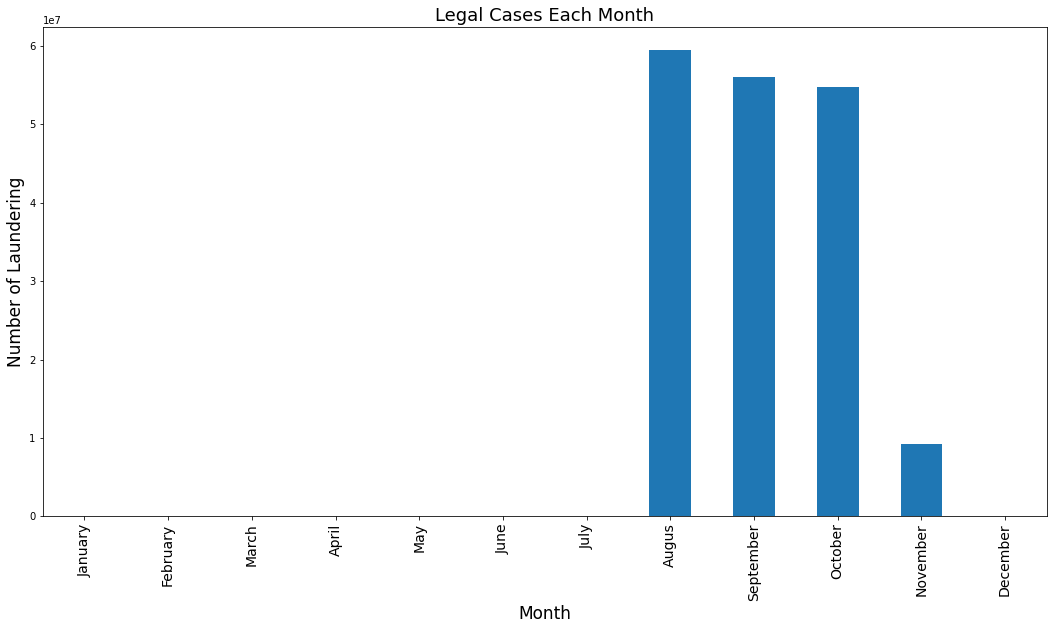

In [268]:
plt.figure(figsize=(18,9))
month_legal_count.plot.bar()
plt.title("Legal Cases Each Month", fontsize = 18)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11],["January", "February", "March", "April", "May", "June", "July", "Augus", "September", "October", "November", "December"], fontsize = 14)
plt.ylabel("Number of Laundering", fontsize = 17)
plt.xlabel("Month", fontsize = 17)


In [100]:

from matplotlib.ticker import FuncFormatter

def millions_formatter(x, pos):
    return f'{x / 1e6:.0f}M'


In [13]:
unique_currencies = df["Payment Currency"].unique().compute()
unique_currencies

0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
Name: Payment Currency, dtype: int64

100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


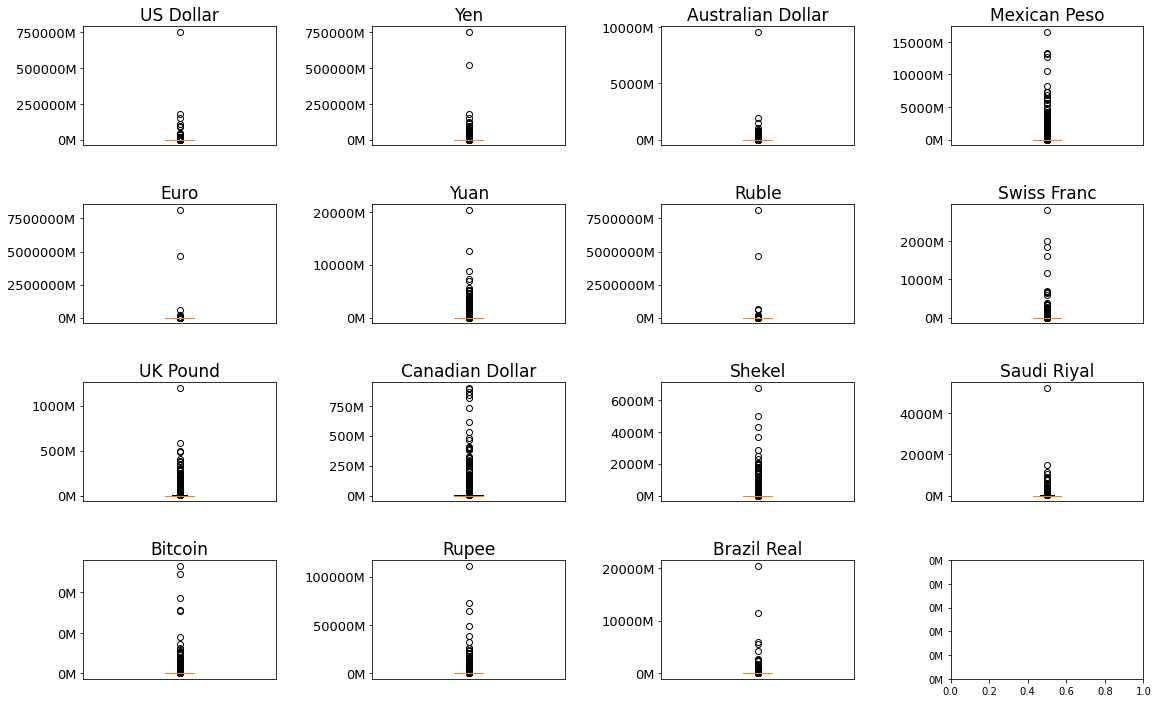

In [222]:

df_amount_received = []

for i in range(len(unique_currencies)):
    df_amount_received.append([])

for i in tqdm(range(2)):
    df_temp = np.array(df.get_partition(i)[["Amount Received", "Payment Currency"]].compute())
    for y in range(len(unique_currencies)):
        df_amount_received[y] = np.append(df_amount_received[y], df_temp[df_temp[:, 1] == unique_currencies[y]][:,0])


fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(19,12))

plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

row = 0
col = 0

for i in range(len(unique_currencies)):
    ax[col,row].boxplot(df_amount_received[i])
    ax[col,row].set_title(unique_currencies[i], fontsize = 17)
    ax[col,row].yaxis.set_major_formatter(FuncFormatter(millions_formatter))
    ax[col,row].set_xticks([])
    ax[col,row].yaxis.set_tick_params(labelsize=13) 

    if(col < 3):
        col += 1
    else:
        col = 0
        row += 1


Label Encode Payment Format

In [7]:
payment_format_mapping = {
    'Reinvestment': 0,
    'Cheque': 1,
    'Credit Card': 2,
    'ACH': 3,
    'Wire': 4,
    'Cash': 5,
    'Bitcoin': 6
}

df['Payment Format'] = df['Payment Format'].map(payment_format_mapping, meta=('x', 'int'))
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022-08-01 00:17:00,20,800104D70,20,800104D70,6794.63,US Dollar,6794.63,US Dollar,0,0
1,2022-08-01 00:02:00,3196,800107150,3196,800107150,7739.29,US Dollar,7739.29,US Dollar,0,0
2,2022-08-01 00:17:00,1208,80010E430,1208,80010E430,1880.23,US Dollar,1880.23,US Dollar,0,0
3,2022-08-01 00:03:00,1208,80010E650,20,80010E6F0,73966883.00,US Dollar,73966883.00,US Dollar,1,0
4,2022-08-01 00:02:00,1208,80010E650,20,80010EA30,45868454.00,US Dollar,45868454.00,US Dollar,1,0


Label Encode Unique Currencies

In [8]:
payment_currency_mapping = {
    'US Dollar': 0,
    'Euro': 1,
    'UK Pound': 2,
    'Bitcoin': 3,
    'Yen': 4,
    'Yuan': 5,
    'Canadian Dollar': 6,
    'Rupee': 7,
    'Australian Dollar': 8,
    'Ruble': 9,
    'Shekel': 10,
    'Brazil Real': 11,
    'Mexican Peso': 12,
    'Swiss Franc': 13,
    'Saudi Riyal': 14,
}

# Use map to label encode 'Payment Currency'
df['Payment Currency'] = df['Payment Currency'].map(payment_currency_mapping, meta=('x', 'int'))
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022-08-01 00:17:00,20,800104D70,20,800104D70,6794.63,US Dollar,6794.63,0,0,0
1,2022-08-01 00:02:00,3196,800107150,3196,800107150,7739.29,US Dollar,7739.29,0,0,0
2,2022-08-01 00:17:00,1208,80010E430,1208,80010E430,1880.23,US Dollar,1880.23,0,0,0
3,2022-08-01 00:03:00,1208,80010E650,20,80010E6F0,73966883.00,US Dollar,73966883.00,0,1,0
4,2022-08-01 00:02:00,1208,80010E650,20,80010EA30,45868454.00,US Dollar,45868454.00,0,1,0


Create new column Same Account, value = 1 if a transaction is from an account to the same account, 0 otherwise

In [9]:
df['Same Account'] = (df['Account'] == df['Account.1']).astype(int)
df['Same Bank'] = (df['To Bank'] == df['From Bank']).astype(int)

df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Same Account,Same Bank
0,2022-08-01 00:17:00,20,800104D70,20,800104D70,6794.63,US Dollar,6794.63,0,0,0,1,1
1,2022-08-01 00:02:00,3196,800107150,3196,800107150,7739.29,US Dollar,7739.29,0,0,0,1,1
2,2022-08-01 00:17:00,1208,80010E430,1208,80010E430,1880.23,US Dollar,1880.23,0,0,0,1,1
3,2022-08-01 00:03:00,1208,80010E650,20,80010E6F0,73966883.00,US Dollar,73966883.00,0,1,0,0,0
4,2022-08-01 00:02:00,1208,80010E650,20,80010EA30,45868454.00,US Dollar,45868454.00,0,1,0,0,0


In [158]:
# Exchange rates of all the Currencies into US dollars, using the average exchange rate of the currencies in 2022
#https://www.irs.gov/individuals/international-taxpayers/yearly-average-currency-exchange-rates

unique_currencies = ["US Dollar", "Euro", "UK Pound", "Bitcoin", "Yen", "Yuan", "Canadian Dollar", "Rupee", "Australian Dollar", "Ruble", "Shekel", "Brazil Real", "Mexican Peso", "Swiss Franc","Saudi Riyal"]
exchange_rates = [1, 0.951, 0.811, 2.32*10**(-5), 131.454, 6.730, 1.301, 78.598, 1.442, 69.896, 3.361, 5.165, 20.110, 0.955, 3.755 ]


def update_rows(partition):
    for i in range(len(unique_currencies)):
        mask = partition['Receiving Currency'] == unique_currencies[i]
        partition.loc[mask, 'Amount Received'] /= exchange_rates[i]
        mask = partition["Payment Currency"] == unique_currencies[i]
        partition.loc[mask, 'Amount Paid'] /= exchange_rates[i]
    return partition

df = df.map_partitions(update_rows,  meta = df)

df.head()
    

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/08/01 00:17,20,800104D70,20,800104D70,6794.63,US Dollar,6794.63,US Dollar,Reinvestment,0
1,2022/08/01 00:02,3196,800107150,3196,800107150,7739.29,US Dollar,7739.29,US Dollar,Reinvestment,0
2,2022/08/01 00:17,1208,80010E430,1208,80010E430,1880.23,US Dollar,1880.23,US Dollar,Reinvestment,0
3,2022/08/01 00:03,1208,80010E650,20,80010E6F0,73966883.00,US Dollar,73966883.00,US Dollar,Cheque,0
4,2022/08/01 00:02,1208,80010E650,20,80010EA30,45868454.00,US Dollar,45868454.00,US Dollar,Cheque,0


In [159]:
df.tail()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
679582,2022/11/05 23:55,70,100428A51,1215340,85212E7D1,3472.715517,Bitcoin,3472.715517,Bitcoin,Bitcoin,0
679583,2022/11/05 23:54,1209449,84E67CBC1,1224000,8521C4F61,890.689655,Bitcoin,890.689655,Bitcoin,Bitcoin,0
679584,2022/11/05 23:41,1215340,8502D35F1,1209449,8521EBFE1,6158.189655,Bitcoin,6158.189655,Bitcoin,Bitcoin,0
679585,2022/11/05 23:39,1215340,8502D35F1,1209449,8521EBFE1,918.448276,Bitcoin,918.448276,Bitcoin,Bitcoin,0
679586,2022/11/05 23:32,1215340,8502D35F1,1209449,8521EBFE1,1675.862069,Bitcoin,1675.862069,Bitcoin,Bitcoin,0


100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


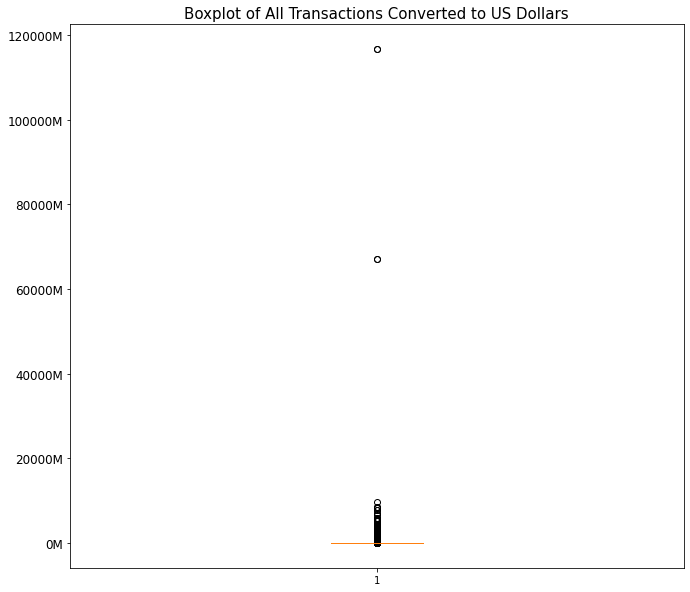

In [160]:
values = []

for i in tqdm(range(5)):
    df_temp = df.get_partition(i).compute()

    values = np.append(values, df_temp["Amount Received"])

plt.figure(figsize=(11,10))
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.title("Boxplot of All Transactions Converted to US Dollars", fontsize = 15)
plt.yticks(fontsize = 12)
plt.xticks([])
_= plt.boxplot(values)



In [137]:
df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/08/01 00:17,20,800104D70,20,800104D70,6794.63,US Dollar,6794.63,US Dollar,Reinvestment,0
1,2022/08/01 00:02,3196,800107150,3196,800107150,7739.29,US Dollar,7739.29,US Dollar,Reinvestment,0
2,2022/08/01 00:17,1208,80010E430,1208,80010E430,1880.23,US Dollar,1880.23,US Dollar,Reinvestment,0
3,2022/08/01 00:03,1208,80010E650,20,80010E6F0,73966883.00,US Dollar,73966883.00,US Dollar,Cheque,0
4,2022/08/01 00:02,1208,80010E650,20,80010EA30,45868454.00,US Dollar,45868454.00,US Dollar,Cheque,0


MAD-based outlier detection is effective for identifying outliers in datasets with skewed or heavy-tailed distributions. 

In [175]:
Median = df["Amount Received"].median_approximate().compute()

In [176]:
MAD = np.median(np.abs(df["Amount Received"] - Median))

In [177]:
threshold = 3
filtered_df_MAD = df[np.abs(df["Amount Received"] - Median) < MAD * threshold]

In [178]:
filtered_df_MAD

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
npartitions=266,,,,,,,,,,,
,object,int64,object,int64,object,float64,object,float64,object,object,int64
,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:09<00:00,  1.80s/it]


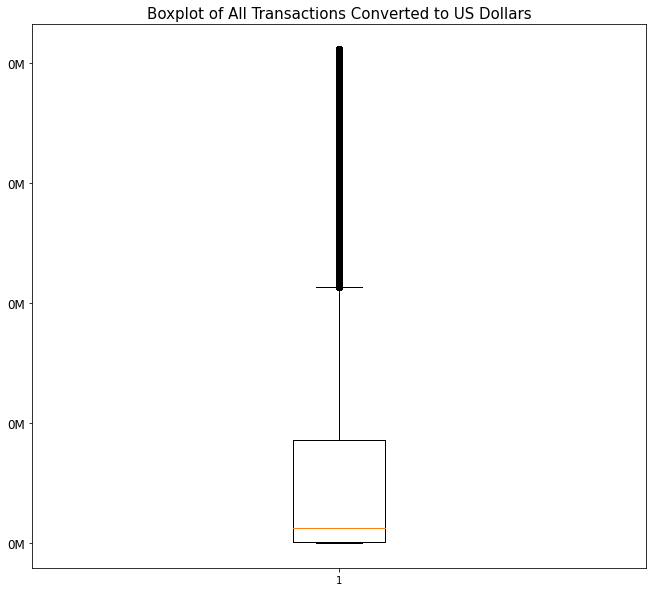

In [182]:
values = []

for i in tqdm(range(5)):
    df_temp = filtered_df_MAD.get_partition(i).compute()

    values = np.append(values, df_temp["Amount Received"])

plt.figure(figsize=(11,10))
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.title("Boxplot of All Transactions Converted to US Dollars", fontsize = 15)
plt.yticks(fontsize = 12)
plt.xticks([])
_= plt.boxplot(values)

(array([1.37442981e+08, 1.14377240e+07, 5.82079300e+06, 3.73183500e+06,
        2.63652600e+06, 1.78824900e+06, 9.83012000e+05, 8.02917000e+05,
        6.48458000e+05, 5.71813000e+05]),
 array([7.60722382e-05, 5.13694507e+03, 1.02738901e+04, 1.54108351e+04,
        2.05477800e+04, 2.56847250e+04, 3.08216700e+04, 3.59586150e+04,
        4.10955600e+04, 4.62325050e+04, 5.13694500e+04]),
 <BarContainer object of 10 artists>)

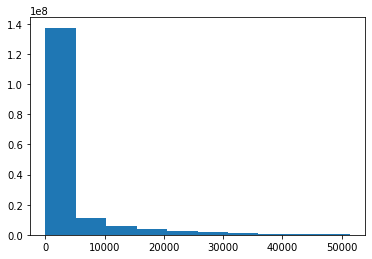

In [172]:
_= plt.hist(values)
plt.title("Distribution of the Amount Received Feature After Outlier Removal")

In [10]:
ar = [1,4,5,3]

for i in range(4):
    plt.boxplot


In [10]:
DF_X = df[[ "From Bank","To Bank", "Receiving Currency" , "Amount Received", "Amount Paid", "Payment Currency", "Payment Format"]]
DF_Y = df[["Is Laundering"]]

from sklearn.model_selection import train_test_split
from sklearn.linear_model  import SGDClassifier

SGD = SGDClassifier()

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model  import SGDClassifier

SGD = SGDClassifier()

Xtest, Ytest = [], []
next_length = 0
length = 0

for i in tqdm(range(df.npartitions)):
    df_temp_X = DF_X.get_partition(i).compute()
    df_temp_Y = DF_Y.get_partition(i).compute()

    df_temp_Y = np.array(df_temp_Y).ravel()
    df_temp_X = label_encode(df_temp_X)

    Xtrain_temp, Xtest_temp, Ytrain_temp, Ytest_temp = train_test_split(df_temp_X, df_temp_Y, test_size= 0.3)
    iter_length = len(df_temp_X)
    next_length += iter_length


    SGD.partial_fit(Xtrain_temp, Ytrain_temp, classes=range(2))
    Xtest.append(Ytest_temp)
    Ytest.append(Ytest)
    
    length +=  iter_length


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265


In [15]:
test = DF_X.get_partition(265).compute()
testtest = DF_Y.get_partition(265).compute()

Xtrain_temp, Xtest_temp, Ytrain_temp, Ytest_temp = train_test_split(test, testtest, test_size= 0.3)


In [17]:
Xtest_temp = label_encode(Xtest_temp)


prediction = SGD.predict(Xtest_temp)

In [19]:
from sklearn.metrics import classification_report


print(classification_report(Ytest_temp, prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    203145
           1       0.00      0.00      0.00       732

    accuracy                           1.00    203877
   macro avg       0.50      0.50      0.50    203877
weighted avg       0.99      1.00      0.99    203877



In [20]:
pd.DataFrame(prediction).value_counts()

0    203647
1       230
dtype: int64